### Import necessary packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import librosa

from sklearn.model_selection import train_test_split

import os

##### Install dependencies and unzip dataset 

In [ ]:
!pip install py7zr
!py7zr x '../input/tensorflow-speech-recognition-challenge/train.7z'
!py7zr x '../input/tensorflow-speech-recognition-challenge/test.7z'

     |████████████████████████████████| 66 kB 822 kB/s eta 0:00:011
     |████████████████████████████████| 2.2 MB 1.7 MB/s eta 0:00:01
     |████████████████████████████████| 1.9 MB 10.1 MB/s eta 0:00:01
     |████████████████████████████████| 124 kB 13.3 MB/s eta 0:00:01


### Create train-dataset

In [2]:
TRAIN_DIR = './train/audio'
labels = os.listdir(TRAIN_DIR)

Dataset of all labels except silence

In [35]:
X = []
Y = []
for label in labels:
    print(label, end=", ")
    path = os.path.join(TRAIN_DIR, label)
    filenames = os.listdir(path)
    for filename in filenames:
        if ".wav" not in filename or label == "_background_noise_":
            continue
        audio, sr = librosa.load(os.path.join(path, filename))
        audio = audio[:sr:10]
        audio = np.pad(audio, (0, 2205-len(audio)), mode="constant", constant_values=0)
        audio = np.reshape(audio, (315,7)) # Reshaping samples to create dataset of shape (TIMESTEP, FEATURES)
        X.append(audio)
        Y.append(labels.index(label))

down, six, eight, yes, stop, happy, marvin, off, wow, nine, left, go, sheila, five, house, tree, four, seven, bed, bird, one, no, two, on, three, right, dog, up, zero, _background_noise_, cat, 

Dataset creation of silence label

In [36]:
label = "_background_noise_"
path = os.path.join(TRAIN_DIR, label)
filenames = os.listdir(path)
for filename in filenames:
    if ".wav" not in filename:
        continue
    audio, sr = librosa.load(os.path.join(path, filename))
    for i in range(0, sr, sr):
        a = audio[i:i+sr:10]
        a = np.pad(a, (0, 2205-len(a)), mode="constant", constant_values=0)
        a = np.reshape(a, (315,7))
        X.append(a)
        Y.append(labels.index(label))

In [37]:
X = np.asarray(X)
Y = np.asarray(Y)
X.shape, Y.shape

((64727, 315, 7), (64727,))

### Train-Test Split

In [38]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

### Model Creation & Training

In [52]:
def Model(X, dropout=0.4):
    _input = tf.keras.layers.Input(X)
    x = tf.keras.layers.LSTM(512, return_sequences=True, dropout=dropout)(_input)
    
    x = tf.keras.layers.LSTM(256, dropout=dropout)(x)
    
    x = tf.keras.layers.Dense(128)(x)
    x = tf.keras.layers.Activation(tf.nn.leaky_relu)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    
    x = tf.keras.layers.Dense(64)(x)
    x = tf.keras.layers.Activation(tf.nn.leaky_relu)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    
    x = tf.keras.layers.Dense(len(labels))(x)
    x = tf.keras.layers.Activation(tf.nn.softmax)(x)
    return tf.keras.Model(_input, x)

In [53]:
model = Model(x_train[0].shape)
model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"])
checkpoint_filepath = "weights_mfcc_Conv2D/"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [56]:
H = model.fit(x_train, y_train, batch_size=128, epochs=500, validation_split=0.25, shuffle=True, callbacks=[model_checkpoint_callback])

Epoch 1/500
285/285 [==============================] - 41s 143ms/step - loss: 3.3954 - accuracy: 0.0374 - val_loss: 3.3917 - val_accuracy: 0.0372
Epoch 2/500
285/285 [==============================] - 41s 144ms/step - loss: 3.3956 - accuracy: 0.0354 - val_loss: 3.3934 - val_accuracy: 0.0353
Epoch 3/500
285/285 [==============================] - 41s 143ms/step - loss: 3.3953 - accuracy: 0.0355 - val_loss: 3.3942 - val_accuracy: 0.0326
Epoch 4/500
285/285 [==============================] - 41s 144ms/step - loss: 3.3951 - accuracy: 0.0367 - val_loss: 3.3930 - val_accuracy: 0.0363
Epoch 5/500
285/285 [==============================] - 41s 143ms/step - loss: 3.3938 - accuracy: 0.0384 - val_loss: 3.3934 - val_accuracy: 0.0352
Epoch 6/500
285/285 [==============================] - 41s 144ms/step - loss: 3.3938 - accuracy: 0.0375 - val_loss: 3.3934 - val_accuracy: 0.0352
Epoch 7/500
285/285 [==============================] - 41s 144ms/step - loss: 3.3944 - accuracy: 0.0363 - val_loss: 3.3923 -

Plot of the train history (X-axis: <i>EPOCHS</i>, Y-axis: <i>ACCURACY</i>)

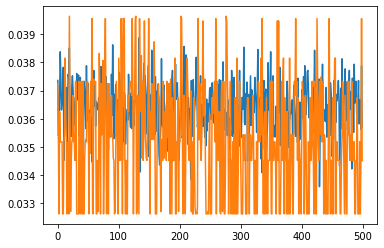

In [57]:
plt.plot(H.history["accuracy"])
plt.plot(H.history["val_accuracy"])

Load the best weights and evaluate the model

In [58]:
model.load_weights("weights_mfcc_Conv2D/")
model.evaluate(x_test, y_test)

506/506 [==============================] - 14s 27ms/step - loss: 3.3944 - accuracy: 0.0343


[3.394416570663452, 0.03429736569523811]